# Introduction

The **[Pima](https://en.wikipedia.org/wiki/Pima_people)** are a group of **Native Americans** living in Arizona. A genetic predisposition allowed this group to survive normally to a diet poor of carbohydrates for years. In the recent years, because of a sudden shift from traditional agricultural crops to processed foods, together with a decline in physical activity, made them develop **the highest prevalence of type 2 diabetes** and for this reason they have been subject of many studies.

## Dataset

The dataset includes data from **768** women with **8** characteristics, in particular:

1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)

The last column of the dataset indicates if the person has been diagnosed with diabetes (1) or not (0)

### Source

The original dataset is available at **UCI Machine Learning Repository** and can be downloaded from this address: http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes

## The problem

The type of dataset and problem is a classic **supervised binary classification**. Given a number of elements all with certain characteristics (features), we want to build a machine learning model to identify people affected by type 2 diabetes.

To solve the problem we will have to analyse the data, do any required transformation and normalisation, apply a machine learning algorithm, train a model, check the performance of the trained model and iterate with other algorithms until we find the most performant for our type of dataset.

# Install Libraries

In [ ]:
import sys
!{sys.executable} -m pip install -r ../model_modules/requirements.txt

In [1]:
import os
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Dataset

The dataset is available to download from [nrvis](http://nrvis.com/data/mldata/pima-indians-diabetes.csv). If you are using the AOA Demo Instance, we already have this dataset preloaded into Teradata.


In [2]:
from teradataml import create_context, DataFrame
import getpass

username = input("Username")
password = getpass.getpass("password")

engine = create_context(host="3.238.151.85", username=username, password=password, logmech="TDNEGO")

password ··········


# Inspect the Dataset

In [3]:
dataset = DataFrame.from_query("""
SELECT 
    F.*, D.hasdiabetes 
FROM pima_patient_features F
JOIN pima_patient_diagnoses D
ON F.patientid = D.patientid
""").to_pandas()


dataset.head()

,PatientId,NumTimesPrg,PlGlcConc,BloodP,SkinThick,TwoHourSerIns,BMI,DiPedFunc,Age,HasDiabetes
0,469,6,154,78,41,140,46.1,0.571,27,0
1,265,5,96,74,18,67,33.6,0.997,43,0
2,734,2,105,75,0,0,23.3,0.560,53,0
3,122,2,107,74,30,100,33.6,0.404,23,0
4,0,6,148,72,35,0,33.6,0.627,50,1


In [4]:
corr = dataset.corr()
corr

,PatientId,NumTimesPrg,PlGlcConc,BloodP,SkinThick,TwoHourSerIns,BMI,DiPedFunc,Age,HasDiabetes
PatientId,1.000000,-0.037201,0.012994,0.020953,0.019006,0.001998,0.012320,-0.040326,0.007714,-0.045184
NumTimesPrg,-0.037201,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
PlGlcConc,0.012994,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodP,0.020953,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThick,0.019006,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
TwoHourSerIns,0.001998,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.012320,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiPedFunc,-0.040326,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.007714,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
HasDiabetes,-0.045184,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


I'm not a doctor and I don't have any knowledge of medicine, but from the data I can guess that **the greater the age or the BMI of a patient is, the greater probabilities are the patient can develop type 2 diabetes**.

# Visualise the Dataset

<AxesSubplot:>

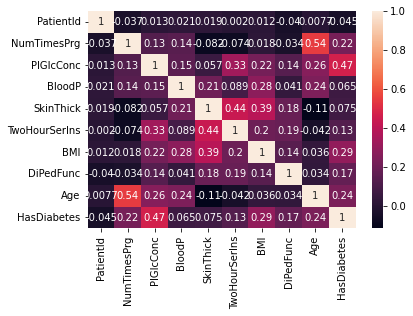

In [5]:
%matplotlib inline
import seaborn as sns
sns.heatmap(corr, annot = True)

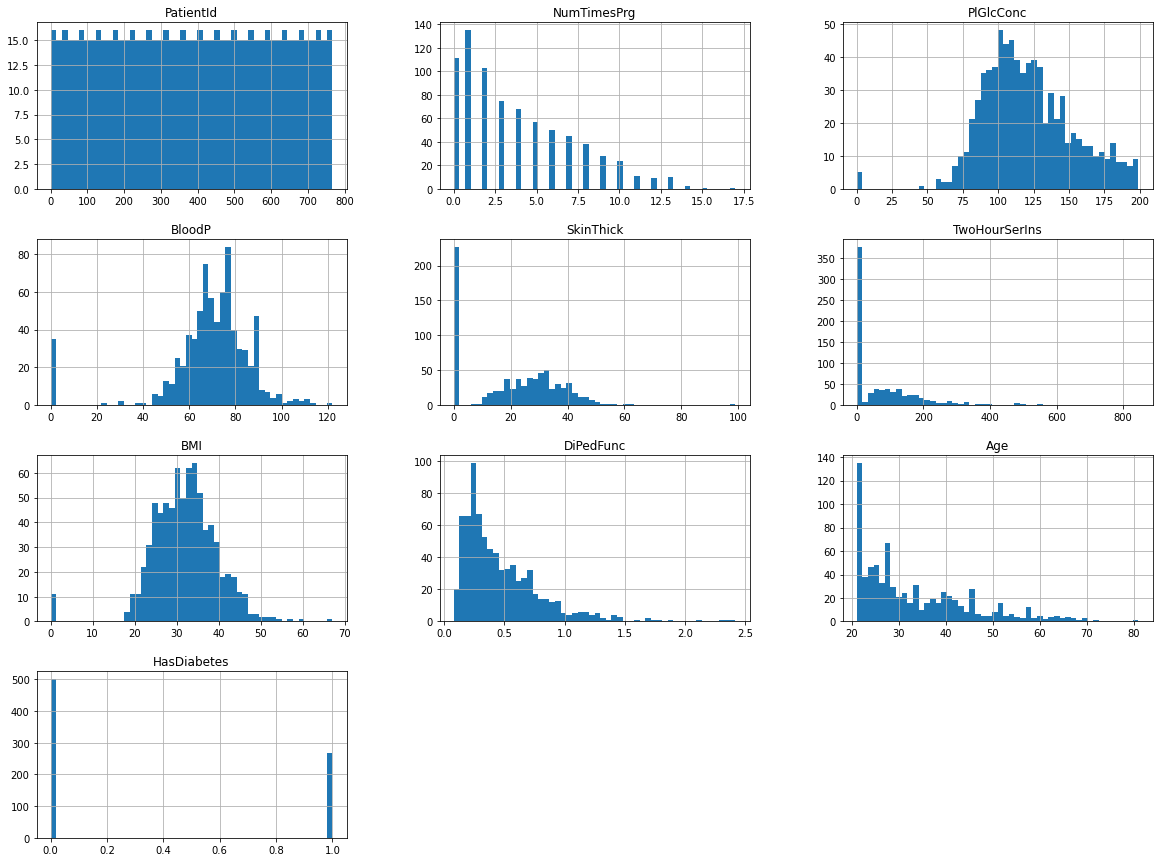

In [6]:
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(20, 15))
plt.show()

An important thing I notice in the dataset (and that wasn't obvious at the beginning) is the fact that some people have **null (zero) values** for some of the features: it's not quite possible to have 0 as BMI or for the blood pressure.

How can we deal with similar values? We will see it later during the **data transformation** phase.

# Splitting the Dataset into Train & Test

As already higlighted in the introduction to the notebook, we have already split the dataset and they are available in PIMA_TRAIN and PIMA_TEST.

In [7]:
from teradataml.dataframe.dataframe import DataFrame

# take 80% split for training
train_set = DataFrame.from_query("""
SELECT 
    F.*, D.hasdiabetes
FROM pima_patient_features F 
JOIN pima_patient_diagnoses D
ON F.patientid = D.patientid
    WHERE D.patientid MOD 5 <> 0
""").to_pandas()

# take 20% split for test
test_set = DataFrame.from_query("""
SELECT 
    F.*, D.hasdiabetes
FROM pima_patient_features F 
JOIN pima_patient_diagnoses D
ON F.patientid = D.patientid
    WHERE D.patientid MOD 5 = 0
""").to_pandas()

In [8]:
# Separate labels from the rest of the dataset
train_set_labels = train_set["HasDiabetes"]
train_set = train_set.drop("HasDiabetes", axis=1)

test_set_labels = test_set["HasDiabetes"]
test_set = test_set.drop("HasDiabetes", axis=1)

# Data cleaning and transformation

We have noticed from the previous analysis that some patients have missing data for some of the features. Machine learning algorithms don't work very well when the data is missing so we have to find a solution to "clean" the data we have.

The easiest option could be to eliminate all those patients with null/zero values, but in this way we would eliminate a lot of important data.

Another option is to calculate the **median** value for a specific column and substitute that value everywhere (in the same column) we have zero or null. Let's see how to apply this second method.

# Feature Scaling

One of the most important data transformations we need to apply is the **features scaling**. Basically most of the machine learning **algorithms don't work very well if the features have a different set of values**. In our case for example the Age ranges from 20 to 80 years old, while the number of times a patient has been pregnant ranges from 0 to 17. For this reason we need to apply a proper transformation.

In [9]:
# Apply a scaler
from sklearn.preprocessing import MinMaxScaler as Scaler

scaler = Scaler()
scaler.fit(train_set)
train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

## Scaled Values

In [10]:
df = pd.DataFrame(data=train_set_scaled)
df.head()

,0,1,2,3,4,5,6,7,8
0,0.610966,0.352941,0.773869,0.639344,0.414141,0.165485,0.687034,0.219014,0.100000
1,0.317232,0.117647,0.733668,0.622951,0.353535,0.229314,0.569300,0.111506,0.133333
2,0.956919,0.117647,0.527638,0.614754,0.000000,0.000000,0.347243,0.214127,0.533333
3,0.157963,0.117647,0.537688,0.606557,0.303030,0.118203,0.500745,0.144825,0.033333
4,0.556136,0.058824,0.909548,0.524590,0.303030,0.212766,0.508197,0.111062,0.283333


# Select and train a model

It's not possible to know in advance which algorithm will work better with our dataset. We need to compare a few and select the one with the "best score".

## Comparing multiple algorithms

To compare multiple algorithms with the same dataset, there is a very nice utility in sklearn called **model_selection**. We create a list of algorithms and then we score them using the same comparison method. At the end we pick the one with the best score.

In [11]:
# Import all the algorithms we want to test
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [12]:
# Import the slearn utility to compare algorithms
from sklearn import model_selection

In [13]:
# Prepare an array with all the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('RFC', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))

In [14]:
# Prepare the configuration to run the test
seed = 7
results = []
names = []
X = train_set_scaled
Y = train_set_labels

In [19]:
# Every algorithm is tested and results are
# collected and printed

for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(
        model, X, Y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

LR: 0.751084 (0.052794)
RFC: 0.760735 (0.049119)
XGB: 0.749233 (0.068579)


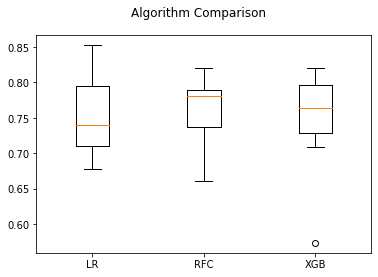

In [ ]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

It looks like that using this comparison method, the most performant algorithm is **XGBoost**.

## Find the best parameters for XGB

The default parameters for an algorithm are rarely the best ones for our dataset. Using sklearn we can easily build a parameters grid and try all the possible combinations. At the end we inspect the `best_estimator_` property and get the best ones for our dataset.

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 6, 8]
}

model_xgb = XGBClassifier()

grid_search = GridSearchCV(model_xgb, param_grid, cv=10, scoring='accuracy')
grid_search.fit(train_set_scaled, train_set_labels)

GridSearchCV(cv=10, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [4, 6, 8]},
             scoring='accuracy')

In [18]:
# Print the bext score found
grid_search.best_score_

0.7524061343204653

## Credits

https://github.com/andreagrandi/ml-pima-notebook